# Getting Started

In [1]:
# Fifty-One related
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob

# Model related
import torch
from PIL import Image
from torchvision.transforms import functional as func

# General
import os
import json
import tqdm

In [2]:
pip list | grep fiftyone

fiftyone                    0.21.0
fiftyone-brain              0.12.0
fiftyone-db                 0.4.0
Note: you may need to restart the kernel to use updated packages.


# Dataset

# BDD100K dataset
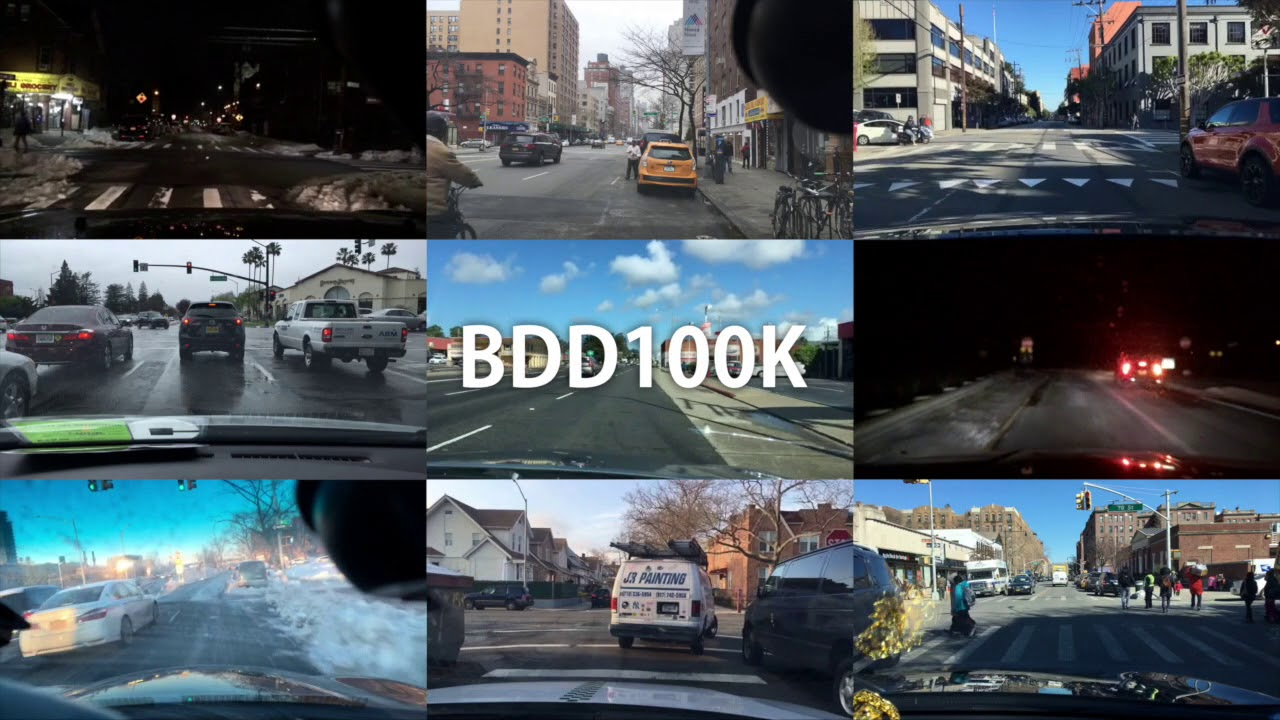

## Use case:
Autonomous cars are finally deployed in Belgium/Netherlands. But The american cars couldn't handle the flocks of cyclists, motorcyclists & LIMEs.

Your task is to adapt an **Object Detection Model** to detect these 'rare' types of vehicles.

In [ ]:
"""if 'bdd100k-validation' in fo.list_datasets():
    print('found dataset on disk.')
    dataset = fo.load_dataset('bdd100k-validation')
else:
    # The path to the source files that you manually downloaded
    source_dir = "./data/bdd100k"

    dataset = foz.load_zoo_dataset(
        "bdd100k",
        split="train",
        source_dir=source_dir,
    )"""

In [ ]:
"""dataset = fo.Dataset(name="all_data")
val_dataset = fo.load_dataset('bdd100k-validation')
train_dataset = fo.load_dataset('bdd100k-train')
dataset.merge_samples(val_dataset)
dataset.merge_samples(train_dataset)
dataset.persistent=True"""

In [3]:
dataset = fo.load_dataset("all_data")

In [ ]:
session = fo.launch_app(dataset)

In [ ]:
session.freeze()

# 1- Random Sampling and baseline model

In [4]:
work_set = dataset.match_tags('demo')

In [ ]:
# random selection
random_train_set = work_set.take(400, seed=42)
for sample in random_train_set:
    sample.tags.append('random_train')
    sample.save()
    
random_val_set = work_set.match_tags("random_train", bool=False).take(100, seed=42)
for sample in random_val_set:
    sample.tags.append('random_val')
    sample.save()

# export to yolov5 format

export_dir = "./train/exp_random_1/"
label_field = "detections"  # for example

# The splits to export
splits = ["train", "val"]

# All splits must use the same classes list
classes = ["bicycle", "rider", "motorcycle"]

# The dataset or view to export
# We assume the dataset uses sample tags to encode the splits to export
dataset_or_view = dataset

# Export the splits
for split in splits:
    split_view = dataset_or_view.match_tags("random_"+split)
    split_view.export(
        export_dir=export_dir,
        #data_path=os.path.join(export_dir,"images"),
        #labels_path=os.path.join(export_dir, "labels"),
        export_media=True,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=classes,
    )

# Train Model
```
! python /home/kais/workspace/yolov5/train.py \
  --weights /home/kais/workspace/pytorch-meetup/models/yolov5s.pt \
  --device 0 \
  --img 1280 \
  --data "exp_random/dataset.yaml" \
  --epochs 5 \
  --batch-size 8 \
  --patience 10 \
  --nosave \
  --project pytorch-demo \
  --name random_selection \
  --seed 96
 ```
 Wandb : https://wandb.ai/kais-bedioui/pytorch-demo/runs/35aucfsr?workspace=user-kais-bedioui

**-----------------------------------------------------------------------------**

# Generate Predictions with Yolov5s model

In [ ]:
session = work_set.match_tags('show')

In [ ]:
# Model configs
MODEL_PATH = 'models/yolov5s.pt'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_CONF = 0.3
MODEL_IOU = 0.7
MODEL_INF_SIZE = 1280

model = torch.hub.load('ultralytics/yolov5', 'custom', path = MODEL_PATH)
model.conf = MODEL_CONF
model.iou = MODEL_IOU
model.to(DEVICE)
model.eval()
print("model ready.")


# Generating Predictions

# Get class list
yolo_classes = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic_light", "fire_hydrant", "stop_sign", "parking_meter", "bench", "bird", "cat", "dog"]

with fo.ProgressBar() as pb:
    for sample in pb(work_set):
        # Load image
        image = Image.open(sample.filepath)
        #image = func.to_tensor(image).to(DEVICE)
        w, h = image.size
        
        # Perform inference
        preds = model([image], size=MODEL_INF_SIZE)
        pd_preds = preds.pandas().xyxy[0]
        
        # Output example
        #         xmin        ymin        xmax        ymax     confidence  class  name
        #0    268.027100  343.181152  454.724304  389.038086    0.975919      0   boat
        #1    608.672668  341.961945  621.594055  347.252838    0.774302      0   boat
        
        if not(pd_preds.empty):
            labels_id = pd_preds['class'].values
            confidence = pd_preds['confidence'].values
            xmin = (pd_preds['xmin'].values) / w
            ymin = (pd_preds['ymin'].values) / h
            xmax = (pd_preds['xmax'].values) / w
            ymax = (pd_preds['ymax'].values) / h
            detections = []
            
            for x1, y1, x2, y2, label, score in zip(xmin, ymin, xmax, ymax, labels_id, confidence):
                box = [x1, y1, x2-x1, y2-y1]
                if label < len(yolo_classes):
                    detections.append(fo.Detection(
                        label=yolo_classes[label],
                        bounding_box=box,
                        confidence=score
                        )
                    )
                else:
                    pass
            
            sample["yolov5_preds"] = fo.Detections(detections=detections)
            sample.save()
            
print("Finished adding predictions")

# Uncertainty Score

In [ ]:
def image_uncertainty(img):
    """
    Uncertainty sampling using 'Least Confidence method'
    """
    if img['yolov5_preds'] and (len(img['yolov5_preds']['detections'])) > 0:
        detections = img['yolov5_preds'].detections
        confs = []
        # Parse detections per image
        for detection in detections:
            if detection['label'] in ['bicycle', 'person', 'motorcycle']:
                confs.append(detection['confidence'])
        if len(confs) > 0:
            least_conf = min(confs)
            # Affect uncertainty to img
            img['uncertainty'] = 1 - least_conf
            img.save()
        else:
            img['uncertainty'] = -1.0
            img.save()
    else:
        img['uncertainty'] = -1.0
        img.save()

In [ ]:
with fo.ProgressBar() as pb:
    for sample in pb(work_set):
        image_uncertainty(sample)
        sample.save()


# Train model with Active Learning approach

## Uncertainty sampling

In [ ]:
data = work_set.sort_by('uncertainty', reverse=True).limit(500)

In [ ]:
for sample in work_set:
    t = sample.tags
    count = t.count('random_val')
    if count == 2:
        sample.tags.remove('random_val')
        sample.save()

In [ ]:
# Uncertainty-based selection
train_set = data.take(400, seed=51)
for sample in train_set:
    if 'active_train' not in sample.tags:
        sample.tags.append('active_train')
    sample.save()
    
val_set = data.match_tags("active_train", bool=False).limit(100)
for sample in val_set:
    if 'active_val' not in sample.tags:
        sample.tags.append('active_val')
    sample.save()

# export to yolov5 format

export_dir = "./train/exp_active_2/"
label_field = "detections"  # for example

# The splits to export
splits = ["train", "val"]

# All splits must use the same classes list
classes = ["bicycle", "rider", "motorcycle"]

# The dataset or view to export
# We assume the dataset uses sample tags to encode the splits to export
dataset_or_view = dataset

# Export the splits
for split in splits:
    split_view = dataset_or_view.match_tags('active_'+split)
    split_view.export(
        export_dir=export_dir,
        #data_path=os.path.join(export_dir,"images", split),
        #labels_path=os.path.join(export_dir, "labels", split),
        export_media=True,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=classes,
    )

# Train Model
! python /home/kais/workspace/yolov5/train.py \
  --weights /home/kais/workspace/pytorch-meetup/models/yolov5s.pt \
  --device 0 \
  --img 1280 \
  --data "exp_active_2/dataset.yaml" \
  --epochs 5 \
  --batch-size 8 \
  --patience 10 \
  --nosave \
  --project pytorch-demo \
  --name random_selection \
  --seed 96
 
wandb run: https://wandb.ai/kais-bedioui/pytorch-demo/runs/3ujuh75b?workspace=user-kais-bedioui

# Image Sampling

In [ ]:
# Compute image uniqueness.

fob.compute_uniqueness(work_set)
dataset.save()

## Image Embeddings

In [ ]:
clip_model = foz.load_zoo_model("clip-vit-base32-torch")
fob.compute_visualization(work_set, brain_key="mbeds")

## Sampling by Diversity

In [ ]:
# Compute embeddings
clip_model = foz.load_zoo_model("clip-vit-base32-torch")
embeddings = work_set.compute_embeddings(clip_model)

# Generate similarity index
results = fob.compute_similarity(
    work_set, embeddings=embeddings, brain_key="sim"
)
# Uniqueness approach
results.find_unique(1000)
# Visualize the unique images in the App
unique_view = work_set.select(results.unique_ids)

In [ ]:
# Uniqueness/embeddings-based selection
train_set = unique_view.take(400, seed=51)
for sample in train_set:
    if 'embed_train' not in sample.tags:
        sample.tags.append('embed_train')
    sample.save()
    
val_set = unique_view.match_tags("embed_train", bool=False).limit(100)
for sample in val_set:
    if 'embed_val' not in sample.tags:
        sample.tags.append('embed_val')
    sample.save()

# export to yolov5 format

export_dir = "./train/exp_uniqueness_1/"
label_field = "detections"  # for example

# The splits to export
splits = ["train", "val"]

# All splits must use the same classes list
classes = ["bicycle", "rider", "motorcycle"]

# The dataset or view to export
# We assume the dataset uses sample tags to encode the splits to export
dataset_or_view = unique_view

# Export the splits
for split in splits:
    split_view = dataset_or_view.match_tags('embed_'+split)
    split_view.export(
        export_dir=export_dir,
        #data_path=os.path.join(export_dir,"images", split),
        #labels_path=os.path.join(export_dir, "labels", split),
        export_media=True,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=classes,
    )

# Train Model
```
! python /home/kais/workspace/yolov5/train.py \
  --weights /home/kais/workspace/pytorch-meetup/models/yolov5s.pt \
  --device 0 \
  --img 1280 \
  --data "exp_uniqueness/dataset.yaml" \
  --epochs 5 \
  --batch-size 8 \
  --patience 10 \
  --nosave \
  --project pytorch-demo \
  --name random_selection \
  --seed 96
 ```

WandB run: https://wandb.ai/kais-bedioui/pytorch-demo/runs/27nk9ozt?workspace=user-kais-bedioui

In [6]:
# Compute embeddings
clip_model = foz.load_zoo_model("clip-vit-base32-torch")
embeddings = work_set.compute_embeddings(clip_model)

# Generate similarity index
results = fob.compute_similarity(
    work_set, embeddings=embeddings, brain_key="imsim"
)
# Uniqueness approach
results.find_unique(1000)
# Visualize the unique images in the App
unique_view = work_set.select(results.unique_ids)

 100% |███████████████| 7377/7377 [39.6s elapsed, 0s remaining, 163.8 samples/s]      
Computing unique samples...
Generating index for 7377 embeddings...
Index complete
threshold: 1.000000, kept: 8, target: 1000
threshold: 0.500000, kept: 1600, target: 1000
threshold: 0.750000, kept: 74, target: 1000
threshold: 0.625000, kept: 387, target: 1000
threshold: 0.562500, kept: 807, target: 1000
threshold: 0.531250, kept: 1147, target: 1000
threshold: 0.546875, kept: 953, target: 1000
threshold: 0.539062, kept: 1055, target: 1000
threshold: 0.542969, kept: 993, target: 1000
threshold: 0.541016, kept: 1015, target: 1000
threshold: 0.541992, kept: 1006, target: 1000
threshold: 0.542480, kept: 999, target: 1000
threshold: 0.542236, kept: 1001, target: 1000
threshold: 0.542358, kept: 1002, target: 1000
threshold: 0.542419, kept: 1000, target: 1000
Uniqueness computation complete


In [7]:
# Visualize the unique images in the App
unique_view = work_set.select(results.unique_ids)

In [ ]:
# Hybrid experience
hybrid_set = unique_view.sort_by('uncertainty', reverse=True)

In [ ]:
val_set

In [ ]:
# Uniqueness/Uncertainty Hybrid selection
train_set = hybrid_set[:400]
for sample in train_set:
    if 'hybrid_train' not in sample.tags:
        sample.tags.append('hybrid_train')
    sample.save()
    
val_set = hybrid_set.match_tags("hybrid_train", bool=False).take(100, seed=42)
for sample in val_set:
    if 'hybrid_val' not in sample.tags:
        sample.tags.append('hybrid_val')
    sample.save()

# export to yolov5 format

export_dir = "./train/exp_hybrid_1/"
label_field = "detections"  # for example

# The splits to export
splits = ["train", "val"]

# All splits must use the same classes list
classes = ["bicycle", "rider", "motorcycle"]

# The dataset or view to export
# We assume the dataset uses sample tags to encode the splits to export
dataset_or_view = unique_view

# Export the splits
for split in splits:
    split_view = dataset_or_view.match_tags('hybrid_'+split)
    split_view.export(
        export_dir=export_dir,
        #data_path=os.path.join(export_dir,"images", split),
        #labels_path=os.path.join(export_dir, "labels", split),
        export_media=True,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=classes,
    )

# Test Set Evaluation

In [ ]:
test_set = work_set.match_tags('test')

In [ ]:
# Model configs
MODEL_PATH = 'models/random.pt'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_CONF = 0.6
MODEL_IOU = 0.7
MODEL_INF_SIZE = 1280
MODEL_TAG = 'random'
PRED_KEY = 'preds_' + MODEL_TAG
EVAL_KEY = 'eval_' + MODEL_TAG


model = torch.hub.load('ultralytics/yolov5', 'custom', path = MODEL_PATH)
model.conf = MODEL_CONF
model.iou = MODEL_IOU
model.to(DEVICE)
model.eval()
print("model ready.")


# Generating Predictions

# Get class list
#yolo_classes = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic_light", "fire_hydrant", "stop_sign", "parking_meter", "bench", "bird", "cat", "dog"]
classes = ["bicycle", "rider", "motorcycle"]

with fo.ProgressBar() as pb:
    for sample in pb(test_set):
        # Load image
        image = Image.open(sample.filepath)
        #image = func.to_tensor(image).to(DEVICE)
        w, h = image.size
        
        # Perform inference
        preds = model([image], size=MODEL_INF_SIZE)
        pd_preds = preds.pandas().xyxy[0]
        
        # Output example
        #         xmin        ymin        xmax        ymax     confidence  class  name
        #0    268.027100  343.181152  454.724304  389.038086    0.975919      0   boat
        #1    608.672668  341.961945  621.594055  347.252838    0.774302      0   boat
        
        if not(pd_preds.empty):
            labels_id = pd_preds['class'].values
            confidence = pd_preds['confidence'].values
            xmin = (pd_preds['xmin'].values) / w
            ymin = (pd_preds['ymin'].values) / h
            xmax = (pd_preds['xmax'].values) / w
            ymax = (pd_preds['ymax'].values) / h
            detections = []
            
            for x1, y1, x2, y2, label, score in zip(xmin, ymin, xmax, ymax, labels_id, confidence):
                box = [x1, y1, x2-x1, y2-y1]
                if label < len(classes):
                    detections.append(fo.Detection(
                        label=classes[label],
                        bounding_box=box,
                        confidence=score
                        )
                    )
                else:
                    pass
            
            sample[PRED_KEY] = fo.Detections(detections=detections)
            sample.save()
            
print("Finished adding predictions")

In [ ]:
results = test_set.evaluate_detections(
    PRED_KEY,
    gt_field="detections",
    eval_key=EVAL_KEY,
    classes=classes,
    method="coco",
    compute_mAP=True,
    iou_threshs=[0.5],
)

print(results.mAP())

## Evaluation Metric

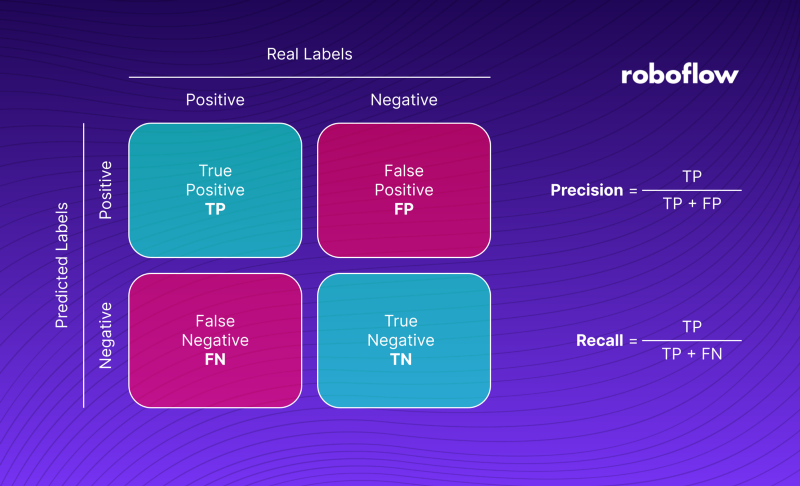  

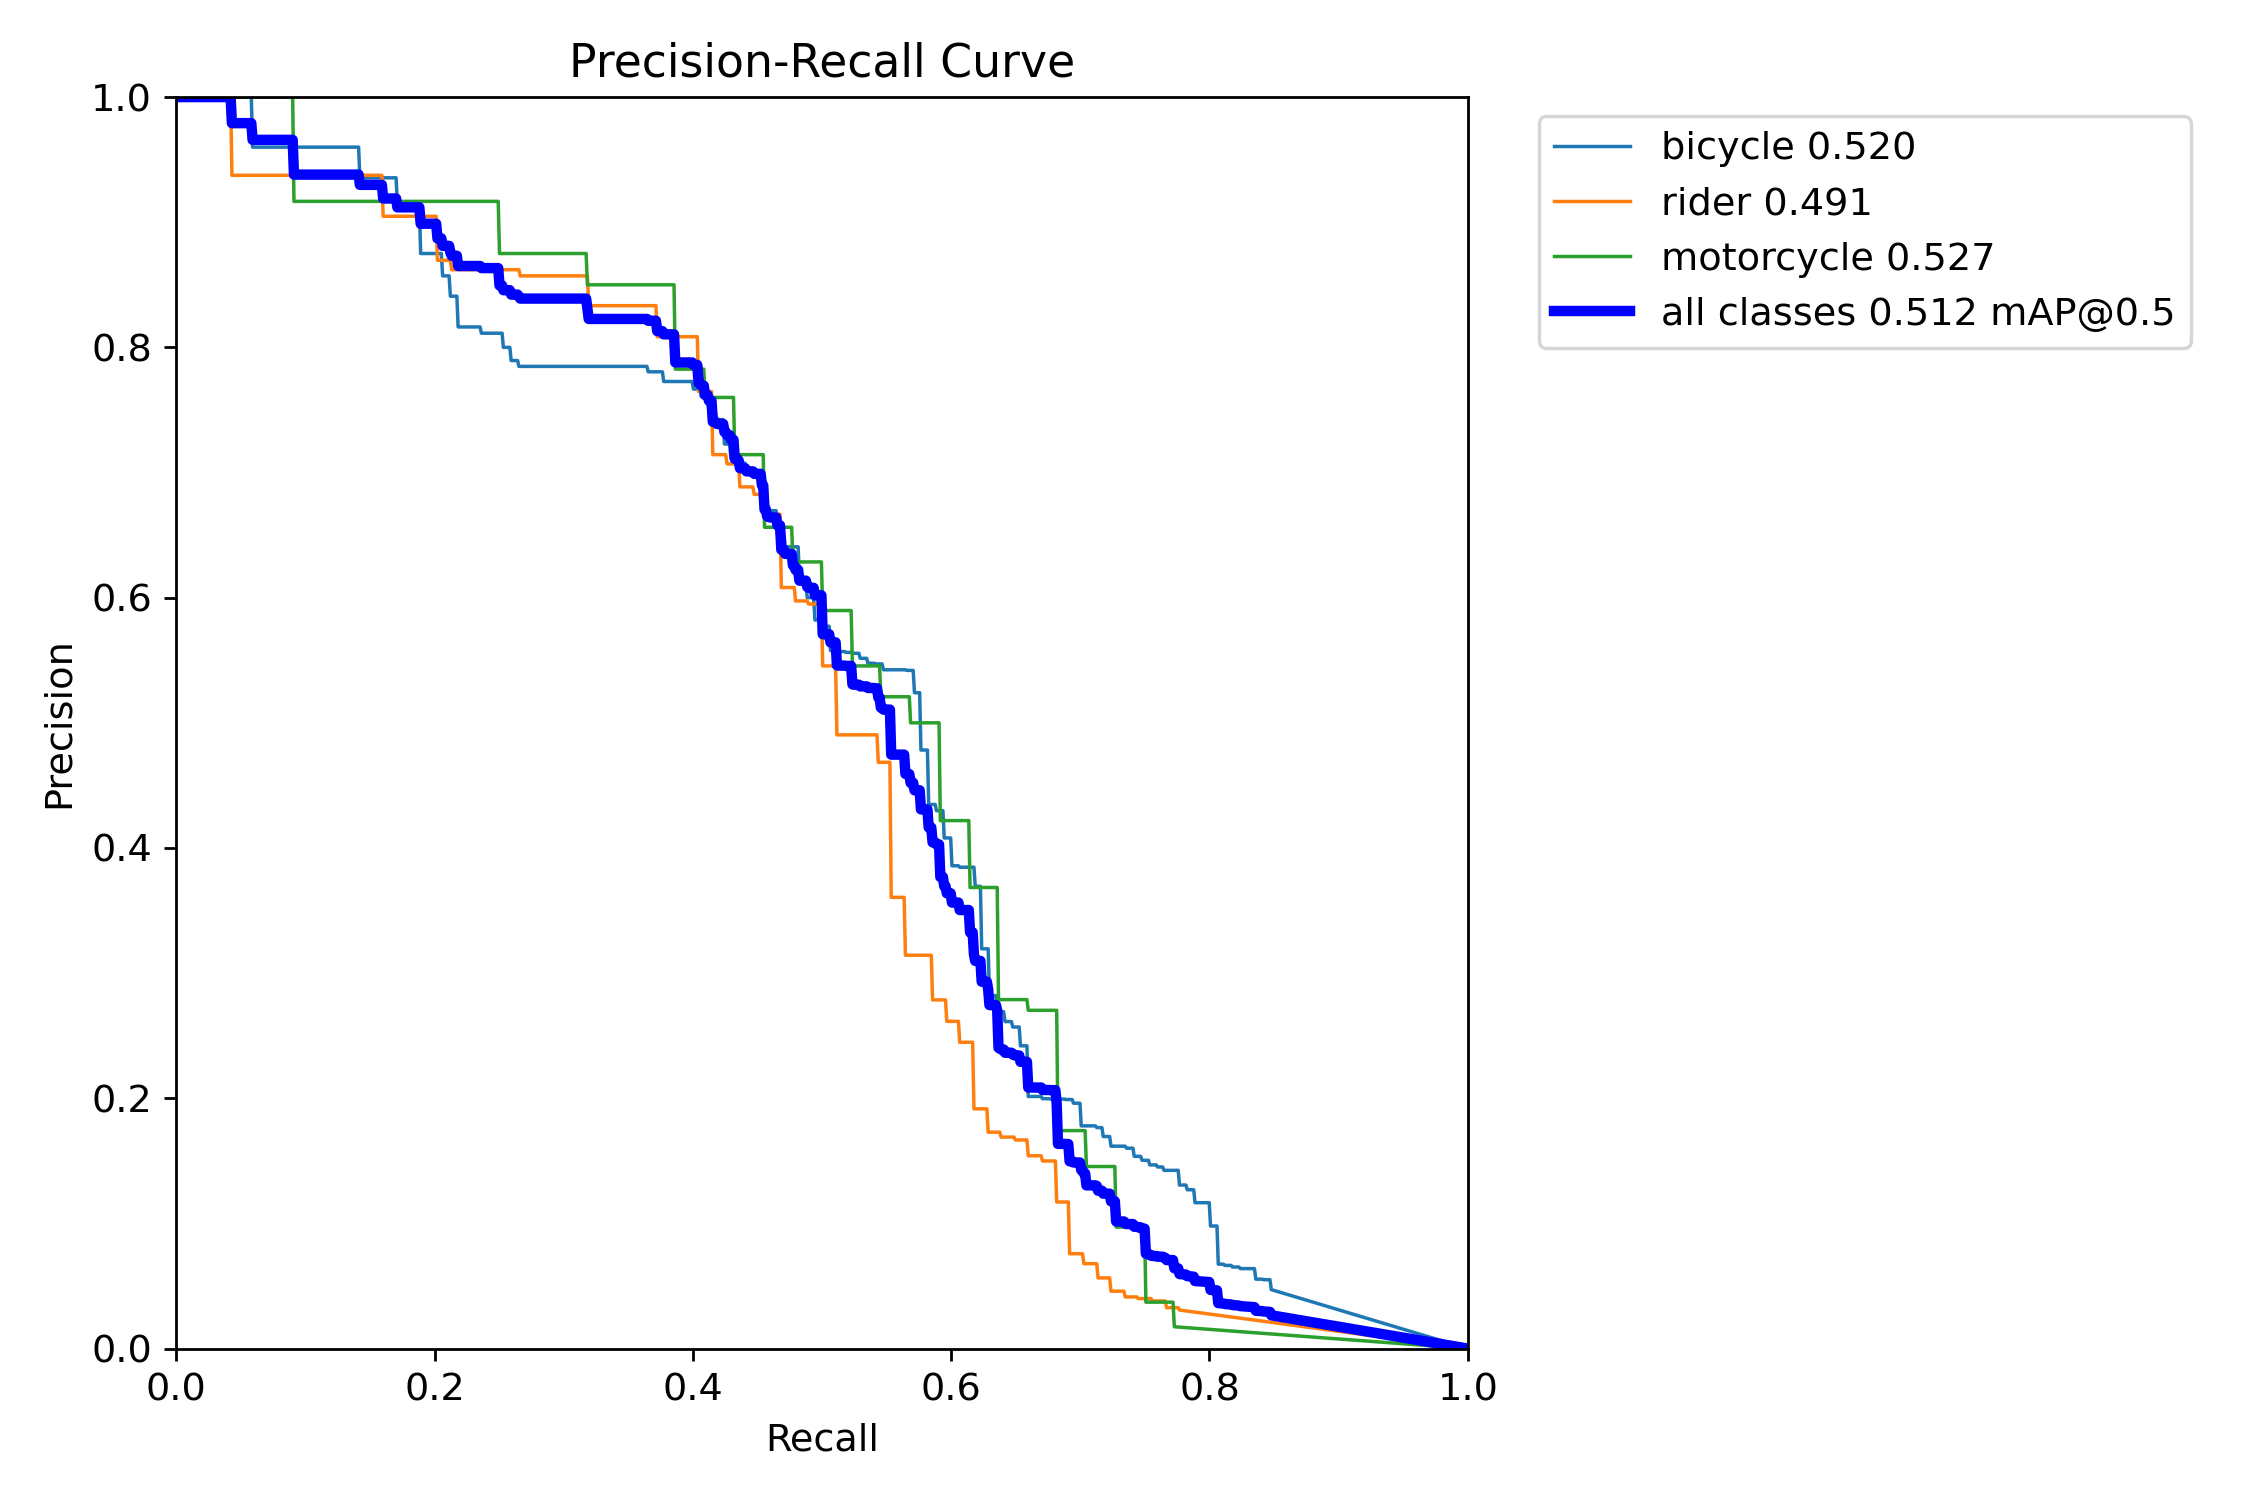

Random sampling -> mAP@0.5: **0.28344137618736204**

Uncertainty scoring -> mAP@0.5: **0.22774777278410407**

Uniqueness sampling -> mAP@0.5: **0.2898240263296116**

Hybrid approach -> mAP@0.5: **0.3215588596245527**